<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Wideband/WidebandAna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%pip -q install uproot
import uproot

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

In [3]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
if False:
  !apt-get -qq install krb5-user
  !wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
  import os
  os.environ['KRB5_CONFIG'] = 'krb5.conf'

  !kinit oksuzian@FNAL.GOV
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/pnfs/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/crvaging-004/root/3d/b4/rec.mu2e.CRV_wideband_cosmics.crvaging-004.001082_000.root drive/MyDrive/Wideband/

In [5]:
root_file = 'drive/MyDrive/Wideband/rec.mu2e.CRV_wideband_cosmics.crvaging-004.001082_000.root'
tree = uproot.open(root_file+":run")
df = tree.arrays(filter_name=['PEs', 'timeSinceSpill', 'spillNumber', 'eventNumber'],library="pd")

/usr/local/lib/python3.7/dist-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]


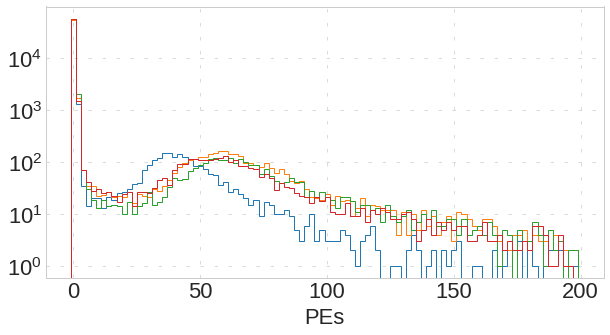

In [6]:
plt.hist(df['PEs[0][63]'], histtype='step', bins=100, range=(-1, 199));
plt.hist(df['PEs[1][63]'], histtype='step', bins=100, range=(-1, 199));
plt.hist(df['PEs[2][63]'], histtype='step', bins=100, range=(-1, 199));
plt.hist(df['PEs[3][63]'], histtype='step', bins=100, range=(-1, 199));
plt.xlabel('PEs')
plt.yscale('log')

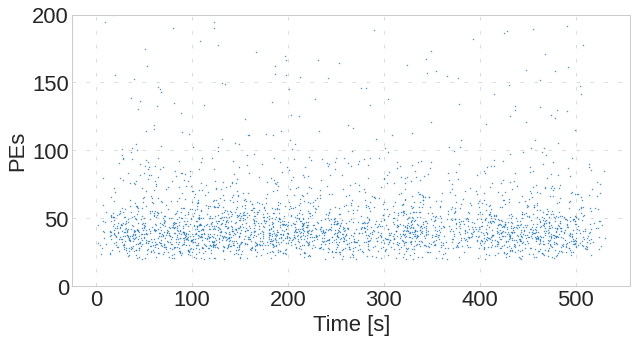

In [7]:
df_cut = df.loc[df['PEs[0][0]']>20]
plt.plot(df_cut['spillNumber'] + df_cut['timeSinceSpill[0][0]']/1e9, df_cut['PEs[0][0]'], '.', markersize=0.8)
plt.ylim(0,200)
plt.ylabel('PEs')
plt.xlabel('Time [s]');

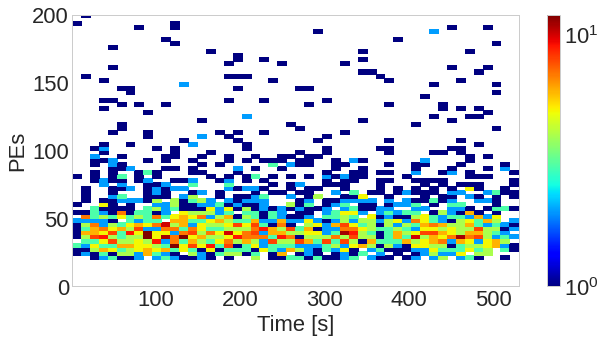

In [8]:
plt.hist2d(df_cut['spillNumber'] + df_cut['timeSinceSpill[0][0]']/1e9, df_cut['PEs[0][0]'], bins=(50,300), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.ylim(0,200)
plt.colorbar()
plt.ylabel('PEs')
plt.xlabel('Time [s]');

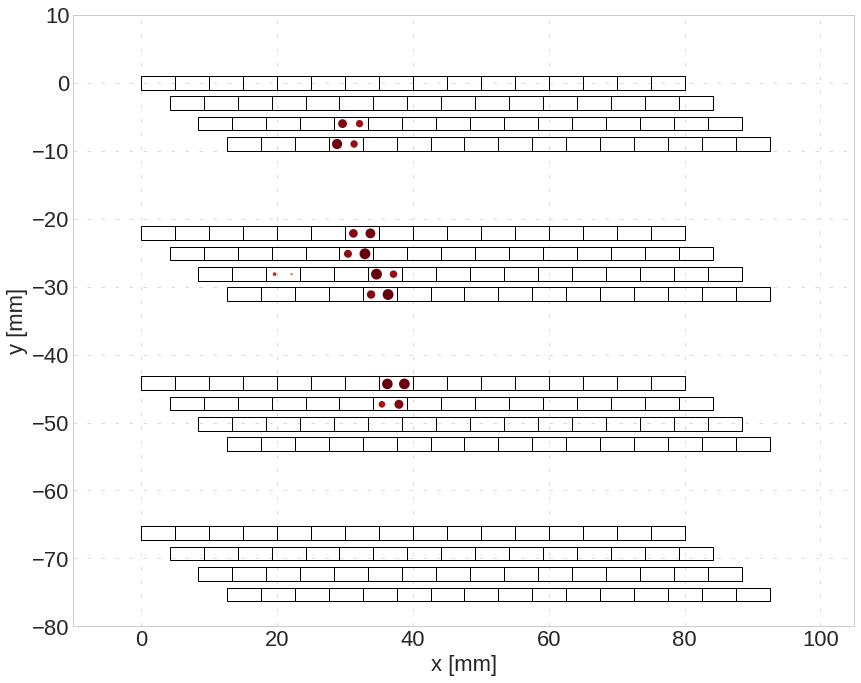

In [9]:
vmax=75
norm = matplotlib.colors.LogNorm(vmin=2, vmax=vmax)
m = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds)
#m = cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)

df_ = df.query('spillNumber==1 and eventNumber==19')

num_modules=4
xy=[]
for x in range(0,15):
  for y in range(0,4):
    for n in range(0,num_modules):
      xy.append([5*x+4.2*y,-y*3-n*22.1]) # FIXME: Gap between modules is 4"=10.16 cm. Why 22.1?

fig, axs = plt.subplots(1,1, figsize=(14,14))
axs.set_aspect(aspect='equal')
axs.set_xlim(-10, 105)
axs.set_ylim(-80, 10)
axs.set_ylabel("y [mm]")
axs.set_xlabel("x [mm]")
for x, y in xy:
    rect1 = plt.Rectangle((x, y-1), 10, 2, fill=None)
    axs.add_patch(rect1)


for feb in range(0,4):
  for chan in range(0,64):
    layer=feb*2+chan//32
    chanLayer = chan%32

    layer = layer+2 # First two layers are empty
    num_modules = layer//4 #Which module based on number of layers
    y = -layer*3
    x = 2.5*chanLayer+4.2*(layer%4)

    z = df_['PEs[%d][%d]'%(feb,chan)].iloc[0]
    z = np.clip(z, 0.1, vmax)
    rect = plt.Circle((x+1.25, y-num_modules*10.16), 0.8*z/vmax, fc=m.to_rgba(z)) 
    axs.add_patch(rect)